<a href="https://colab.research.google.com/github/rashida048/time-series-forecasting-with-tensorflow/blob/main/Sunspots_time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format = "-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [6]:
import pandas as pd
df = pd.read_csv("Sunspots.csv")
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


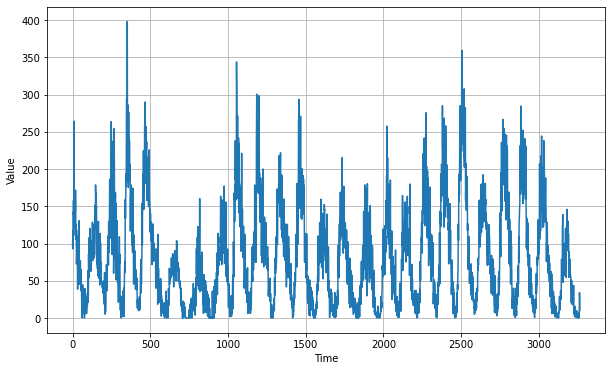

In [9]:
from pandas.io.parsers import readers
import csv 
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [10]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32 
shuffle_buffer_size = 1000

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [18]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [20]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 10s 401ms/step - loss: 79.8340 - mae: 80.3314 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 5s 357ms/step - loss: 78.0944 - mae: 78.5918 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 5s 363ms/step - loss: 75.4519 - mae: 75.9497 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 5s 364ms/step - loss: 72.2679 - mae: 72.7658 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 5s 361ms/step - loss: 68.7693 - mae: 69.2672 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 5s 359ms/step - loss: 65.1128 - mae: 65.6099 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 5s 364ms/step - loss: 61.5272 - mae: 62.0241 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 5s 355ms/step - loss: 58.1406 - mae: 58.6369 - lr: 2.2387e-08
Epoch 9/100
12/12 [==============================] - 5s 365ms/step - loss: 55.0

(1e-08, 0.0001, 0.0, 60.0)

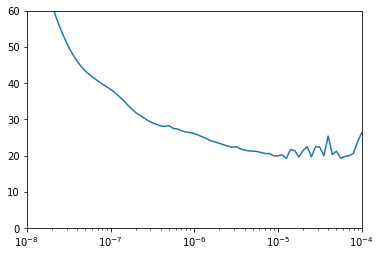

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 10s 151ms/step - loss: 38.9180 - mae: 39.4144
Epoch 2/500
30/30 [==============================] - 5s 148ms/step - loss: 25.7652 - mae: 26.2597
Epoch 3/500
30/30 [==============================] - 5s 148ms/step - loss: 22.0764 - mae: 22.5701
Epoch 4/500
30/30 [==============================] - 6s 179ms/step - loss: 20.4606 - mae: 20.9535
Epoch 5/500
30/30 [==============================] - 5s 157ms/step - loss: 19.7099 - mae: 20.2024
Epoch 6/500
30/30 [==============================] - 5s 152ms/step - loss: 19.3147 - mae: 19.8068
Epoch 7/500
30/30 [==============================] - 5s 154ms/step - loss: 18.7048 - mae: 19.1970
Epoch 8/500
30/30 [==============================] - 5s 152ms/step - loss: 18.1249 - mae: 18.6166
Epoch 9/500
30/30 [==============================] - 5s 150ms/step - loss: 18.0666 - mae: 18.5581
Epoch 10/500
30/30 [==============================] - 5s 153ms/step - loss: 17.9098 - mae: 18.4011
Epoch 11/500
30/30

In [23]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

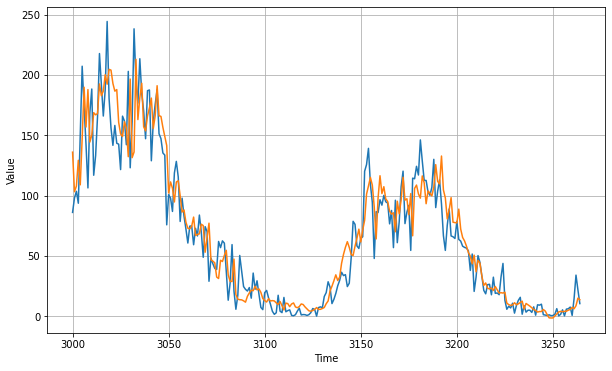

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.348697

<Figure size 432x288 with 0 Axes>

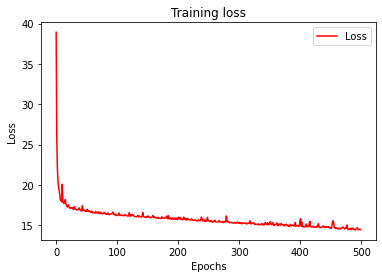

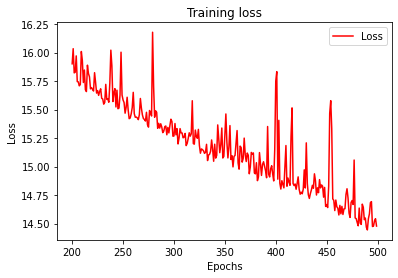

<Figure size 432x288 with 0 Axes>

In [26]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [27]:
print(rnn_forecast)

[ 1.35939484e+02  1.03122353e+02  1.07854065e+02  1.29223846e+02
  1.08848190e+02  1.47394867e+02  1.89780869e+02  1.56790619e+02
  1.87813980e+02  1.44311218e+02  1.50012405e+02  1.68677536e+02
  1.66905807e+02  1.67967682e+02  1.92483276e+02  1.82719696e+02
  1.86667938e+02  2.00119476e+02  1.92287476e+02  2.04571106e+02
  2.03981857e+02  1.92893570e+02  1.86521866e+02  1.87829178e+02
  1.60574875e+02  1.51088425e+02  1.48912125e+02  1.61187332e+02
  1.56054123e+02  1.32184387e+02  1.96561844e+02  1.31382050e+02
  1.36063919e+02  2.12918182e+02  1.62957764e+02  1.81050842e+02
  1.93076706e+02  1.57009201e+02  1.53598175e+02  1.65926987e+02
  1.72638885e+02  1.80771622e+02  1.55543762e+02  1.66109390e+02
  1.91042328e+02  1.66128891e+02  1.65595352e+02  1.56555115e+02
  1.48850113e+02  1.41433136e+02  1.02085449e+02  1.11270630e+02
  1.06038406e+02  9.46560745e+01  1.11224770e+02  1.12193611e+02
  9.97233887e+01  8.63376236e+01  8.79986877e+01  7.78554077e+01
  7.28274841e+01  7.24228